# **Detecting Alzheimer's with Vision Transformer (ViT)**  
### *Baseline Deliverable*

---

## **Group Members**
- **Sheraz Waseem** – *26100026*  
- **Umair Amir** – *26100148*  

---

## Dataset: OASIS-2

The OASIS-2 dataset is a longitudinal collection of brain MRI scans used to study aging and Alzheimer's Disease progression.

### Key Details:
- **Subjects:** 150 elderly individuals aged 60–96  
- **Scans:** Multiple T1-weighted scans per subject  
- **Labels:** Binary classification of *"Demented"* vs *"Nondemented"*  
- **Data Cleaning:** Removed *"Converted"* cases to create a cleaner binary classification task  

---

## Model Architecture: Pretrained ViT (Hugging Face)

Our approach leverages transfer learning with a Vision Transformer (ViT) model.

### Vision Transformer (ViT) Backbone
- **Architecture:** Based on Dosovitskiy et al.'s Vision Transformer  
- **Patch projection:** Each 128 × 128 slice is split into 16 × 16 patches, yielding 64 tokens per slice. Tokens are flattened and linearly embedded to `d = 768`.  
- **Positional encodings:** Learnable encodings added at the slice token level to retain intra-slice geometry  
- **Transformer encoder:** 12 layers, 12-head self-attention, feed-forward width 3072 with GELU activation  
- **Classification scheme:** Binary classification using a single neuron with sigmoid activation (`"Nondemented"` vs `"Demented"`)  

---

## Pipeline Overview

### Data Preprocessing
- Raw `.hdr` and `.img` volumes are parsed using **NiBabel**
- For each orientation (**axial**, **coronal**, **sagittal**), middle slices are extracted
- Each slice is normalized and resized to **224×224**
- Three middle slices (one from each orientation) are combined into an **RGB image**

### Dataset Construction
- Subjects are filtered to include only `"Demented"` and `"Nondemented"` classes
- MRI scans are matched to subject labels from the OASIS-2 Excel sheet
- **Train-test split:** 80/20 stratified by diagnosis
- Custom **PyTorch Dataset** class handles on-the-fly image processing

---

## Model Training

- **Base Model:** `google/vit-base-patch16-224-in21k` (pretrained)  
- **Loss Function:** Binary cross-entropy  
- **Optimizer:** AdamW  
  - Learning rate: `1e-5`  
  - Weight decay: `1e-4`  
- **Training:**  
  - 20 epochs  
  - Batch size: 8  
- **Model Selection:** Best model selected based on **F1 score**

---

## Evaluation

- **Performance metrics:** Accuracy and **weighted F1 score**
- Metrics calculated **per epoch** to monitor training progress
- Best model saved based on **validation F1 score**

---


## Connecting to Google Drive to Access Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Extracting dataset zip file

In [3]:
import tarfile

file_path = '/content/drive/MyDrive/OasisDataset2/OAS2_RAW_PART1.tar.gz'
extract_path = '/content/oasis_data'

with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)

print("Extraction complete.")

Extraction complete.


In [ ]:
import os, shutil, pandas as pd

XL_PATH   = "/content/drive/MyDrive/OasisDataset2/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx"
DATA_ROOT = "/content/oasis_data/OAS2_RAW_PART1"
TRASH_DIR = "/content/converted_scans_backup"  

df = pd.read_excel(XL_PATH)

converted_ids = df.loc[df["Group"].eq("Converted"), "MRI ID"].unique().tolist()
print(f"Found {len(converted_ids)} converted visits")

os.makedirs(TRASH_DIR, exist_ok=True)

for mri_id in converted_ids:
    src = os.path.join(DATA_ROOT, mri_id)  
    if not os.path.isdir(src):
        print(f"[WARN] {src} not found, skipping")
        continue

    dst = os.path.join(TRASH_DIR, mri_id)
    shutil.move(src, dst)                

    print(f"✓ removed {mri_id}")

print("Done!")

Found 37 converted visits
✓ removed OAS2_0018_MR1
✓ removed OAS2_0018_MR3
✓ removed OAS2_0018_MR4
✓ removed OAS2_0020_MR1
✓ removed OAS2_0020_MR2
✓ removed OAS2_0020_MR3
✓ removed OAS2_0031_MR1
✓ removed OAS2_0031_MR2
✓ removed OAS2_0031_MR3
✓ removed OAS2_0041_MR1
✓ removed OAS2_0041_MR2
✓ removed OAS2_0041_MR3
✓ removed OAS2_0054_MR1
✓ removed OAS2_0054_MR2
✓ removed OAS2_0092_MR1
✓ removed OAS2_0092_MR2
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0103_MR1 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0103_MR2 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0103_MR3 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0118_MR1 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0118_MR2 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0127_MR1 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0127_MR2 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0127_MR3 no

In [ ]:

!pip -q install -U "transformers>=4.41.0" "huggingface_hub>=0.23.0" accelerate \
                nibabel pandas scikit-learn tqdm pillow

import os, json, numpy as np, pandas as pd, nibabel as nib, torch
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

EXCEL = "/content/drive/MyDrive/OasisDataset2/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx"
ROOT  = "/content/oasis_data/OAS2_RAW_PART1"          
CFG   = "/content/vit_2class.json"

cfg_json = {
    "_name_or_path": "google/vit-base-patch16-224-in21k",
    "architectures": ["ViTForImageClassification"],
    "image_size": 224,
    "patch_size": 16,
    "hidden_size": 768,
    "num_hidden_layers": 12,
    "num_attention_heads": 12,
    "intermediate_size": 3072,
    "hidden_act": "gelu",
    "initializer_range": 0.02,
    "layer_norm_eps": 1e-12,
    "qkv_bias": True,
    "num_channels": 3,
    "id2label": {"0": "Nondemented", "1": "Demented"},
    "label2id": {"Nondemented": 0, "Demented": 1},
}
with open(CFG, "w") as f: json.dump(cfg_json, f)


def three_views_rgb(hdr_path):
    """Return a PIL RGB image (224 × 224) built from the middle axial,
    coronal, sagittal slices. Handles 3-D or 4-D NIfTI volumes."""
    vol = nib.load(hdr_path).get_fdata().astype(np.float32)

    vol = np.squeeze(vol)
    if vol.ndim == 4:                       
        vol = vol[..., 0]
    if vol.ndim != 3:
        raise ValueError(f"Unexpected volume shape {vol.shape}")

    cx, cy, cz = np.array(vol.shape) // 2
    slices = [vol[cx, :, :], vol[:, cy, :], vol[:, :, cz]]

    def to_pil(slice2d):
        s_min, s_max = slice2d.min(), slice2d.max()
        if s_max > s_min:
            sl = ((slice2d - s_min) / (s_max - s_min) * 255).astype(np.uint8)
        else:
            sl = np.zeros_like(slice2d, dtype=np.uint8)
        return Image.fromarray(sl).resize((224, 224), Image.BILINEAR)

    triplet = [np.array(to_pil(s)) for s in slices]     
    stacked = np.stack(triplet, axis=-1)                
    return Image.fromarray(stacked)

df = pd.read_excel(EXCEL)
df = df[df["Group"].isin(["Nondemented", "Demented"])][["MRI ID", "Group"]].drop_duplicates()

records = []
for mri_id, label in tqdm(df.values, total=len(df)):
    raw_dir = os.path.join(ROOT, mri_id, "RAW")
    if not os.path.isdir(raw_dir):
        continue
    hdrs = [f for f in sorted(os.listdir(raw_dir)) if f.endswith(".hdr")]
    if hdrs:
        records.append({"hdr_path": os.path.join(raw_dir, hdrs[0]), "label": label})

clean_df = pd.DataFrame(records)
print("Usable scans:", len(clean_df))

from torch.utils.data import Dataset

label2id = {"Nondemented": 0, "Demented": 1}

class OasisSliceDataset(Dataset):
    def __init__(self, df_subset, processor):
        self.df = df_subset.reset_index(drop=True)
        self.processor = processor

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row  = self.df.iloc[idx]
        img  = three_views_rgb(row.hdr_path)            
        enc  = self.processor(img, return_tensors="pt")
        enc["labels"] = torch.tensor(label2id[row.label])
        enc["pixel_values"] = enc["pixel_values"].squeeze(0)
        return enc


train_df, val_df = train_test_split(
    clean_df, test_size=0.2, stratify=clean_df["label"], random_state=42
)
print(len(train_df), "train |", len(val_df), "val")

from transformers import (
    ViTConfig,
    ViTForImageClassification,
    ViTImageProcessor,
    TrainingArguments,
    Trainer,
    DefaultDataCollator,
)
from sklearn.metrics import accuracy_score, f1_score

config = ViTConfig.from_json_file(CFG)
model  = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    config=config,
    ignore_mismatched_sizes=True,    
)

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

train_set = OasisSliceDataset(train_df, processor)
val_set   = OasisSliceDataset(val_df,   processor)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1":       f1_score(labels, preds, average="weighted"),
    }

args = TrainingArguments(
    output_dir                = "/content/vit_oasis_ckpts",
    per_device_train_batch_size= 8,
    per_device_eval_batch_size = 8,
    num_train_epochs          = 20,
    learning_rate             = 1e-5,
    weight_decay              = 1e-4,
    eval_strategy       = "epoch",
    save_strategy             = "epoch",
    load_best_model_at_end    = True,
    metric_for_best_model     = "f1",
    seed                      = 42,
    logging_strategy          = "epoch",
)

trainer = Trainer(
    model           = model,
    args            = args,
    data_collator   = DefaultDataCollator(),
    train_dataset   = train_set,
    eval_dataset    = val_set,
    compute_metrics = compute_metrics,
)

trainer.train()




  0%|          | 0/336 [00:00<?, ?it/s]

Usable scans: 193
154 train | 39 val


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.682500,0.690114,0.564103,0.463002
2,0.616300,0.695611,0.641026,0.591492
3,0.561800,0.699238,0.512821,0.516705
4,0.491500,0.726051,0.538462,0.523956
5,0.411000,0.740825,0.538462,0.538462
6,0.318700,0.740806,0.538462,0.532692
7,0.238800,0.778782,0.564103,0.565864
8,0.178600,0.809779,0.589744,0.589744
9,0.128600,0.850816,0.615385,0.618451
10,0.098600,0.889785,0.589744,0.589744


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.682500,0.690114,0.564103,0.463002
2,0.616300,0.695611,0.641026,0.591492
3,0.561800,0.699238,0.512821,0.516705
4,0.491500,0.726051,0.538462,0.523956
5,0.411000,0.740825,0.538462,0.538462
6,0.318700,0.740806,0.538462,0.532692
7,0.238800,0.778782,0.564103,0.565864
8,0.178600,0.809779,0.589744,0.589744
9,0.128600,0.850816,0.615385,0.618451
10,0.098600,0.889785,0.589744,0.589744


TrainOutput(global_step=400, training_loss=0.20937425002455712, metrics={'train_runtime': 880.5425, 'train_samples_per_second': 3.498, 'train_steps_per_second': 0.454, 'total_flos': 2.3867532801294336e+17, 'train_loss': 0.20937425002455712, 'epoch': 20.0})

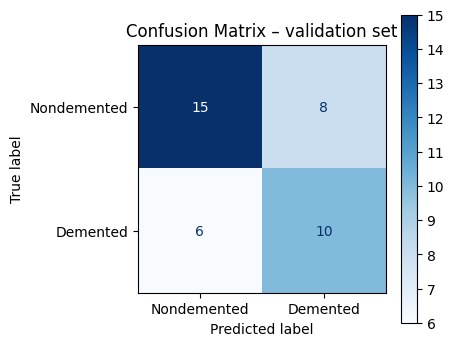

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred_out = trainer.predict(val_set)
y_true   = pred_out.label_ids
y_pred   = np.argmax(pred_out.predictions, axis=-1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Nondemented", "Demented"])

fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - validation set")
plt.show()

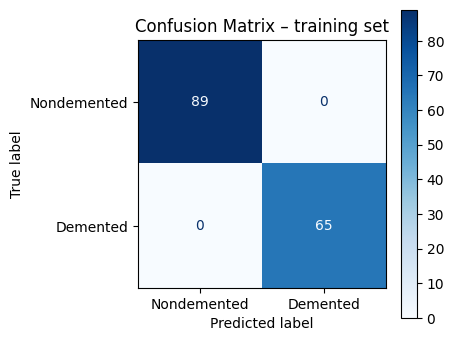

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pred_out = trainer.predict(train_set)
y_true   = pred_out.label_ids
y_pred   = np.argmax(pred_out.predictions, axis=-1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Nondemented", "Demented"])

fig, ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - training set")
plt.show()